<a href="https://colab.research.google.com/github/SVinodNayak/Pytorch-for-Deep-Learning/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#convert MNIST files into a tensor of 4-Dimensions(height,image,width,color channel)
transform=transforms.ToTensor()

In [4]:
#train data
train_data=datasets.MNIST(root='/cnn_data',train=True,download=True,transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 50758912.10it/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 3465376.30it/s]

Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3359862.90it/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1537945.33it/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [5]:
#test data
test_data=datasets.MNIST(root='/cnn_data',train=False,download=True,transform=transform)


In [6]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
#create a batch size for imahes  ...>lets say 10
train_loader=DataLoader(train_data,batch_size=10,shuffle=True)
test_loader=DataLoader(test_data,batch_size=10,shuffle=False)


In [12]:
#define our CNN model
conv1=nn.Conv2d(1,6,3,1)
conv2=nn.Conv2d(6,16,3,1)
fc1=nn.Linear(5*5*16,120)
fc2=nn.Linear(120,84)
fc3=nn.Linear(84,10)

In [13]:
#grab 1 MNIST record/images
for i,(X_train,y_train) in enumerate(train_data):
    break

In [14]:
X_train.shape

torch.Size([1, 28, 28])

In [15]:
x=X_train.view(1,1,28,28)

In [18]:
#perform our first convulution
x=F.relu(conv1(x))


RuntimeError: Given groups=1, weight of size [6, 1, 3, 3], expected input[1, 6, 26, 26] to have 1 channels, but got 6 channels instead

In [20]:
#1 single image,6->filters, 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [21]:
# pass thru pooling layer
x=F.max_pool2d(x,2,2)#kernel of 2 and stride of 2

In [22]:
x.shape#26 / 2 =13

torch.Size([1, 6, 13, 13])

In [24]:
#do our second convolutional layer
x=F.relu(conv2(x))

In [25]:
x.shape #again we didn't set padding so we lose 2 pixels around the outside of the image

torch.Size([1, 16, 11, 11])

In [26]:
#poling layer
x=F.max_pool2d(x,2,2)

In [27]:
x.shape

torch.Size([1, 16, 5, 5])

In [33]:
#model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3,1)
    self.conv2=nn.Conv2d(6,16,3,1)
    #fully connected layer
    self.fc1=nn.Linear(5*5*16,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)

  def forward(self,X):
    X=F.relu(self.conv1(X))
    X=F.max_pool2d(X,2,2)
    #second pass
    X=F.relu(self.conv2(X))
    X=F.max_pool2d(X,2,2)

    #re-view to flatten it out
    X=X.view(-1,16*5*5) #negative one  so that we can vary the batch size
    #fully connected layers
    X=F.relu(self.fc1(X))
    X=F.relu(self.fc2(X))
    X=self.fc3(X)
    return F.log_softmax(X,dim=1)


In [34]:
#create an instance of our model
torch.manual_seed(41)
model=ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [37]:
#Loss function and  Optimizer
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)


In [38]:
import time
start_time=time.time()
#create variables to tracks things
epochs=5
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]
#for loop for epochs
for i in range(epochs):
  trn_cor=0
  tst_cor=0

  #training
  for b,(X_train,y_train) in enumerate(train_loader):
    b+=1 #start our batches at 1
    y_pred=model(X_train)
    loss=criterion(y_pred,y_train)
    predicted=torch.max(y_pred.data,1)[1]#add up the no.of correct predictions. Indexed off the first point
    batch_correct = (predicted==y_train).sum()# how many we got correct from this batch
    trn_cor += batch_correct#keep track as we go along in training
    #update the parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print out the some results
    if b%600==0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
  train_losses.append(loss)
  train_correct.append(trn_cor)
  #testing
  with torch.no_grad():# No gradient so we dont update our weights and biases with test data
    for b,(X_test,y_test) in enumerate(test_loader):
      y_val=model(X_test)
      predicted=torch.max(y_val.data,1)[1]#adding up correct predictions
      tst_cor += (predicted == y_test).sum()


  loss=criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(tst_cor)


current_time=time.time()
total=current_time-start_time
print(f"Training took: {total/60} minutes")

Epoch: 0 Batch: 600 Loss: 0.1623610556125641
Epoch: 0 Batch: 1200 Loss: 0.1502392590045929
Epoch: 0 Batch: 1800 Loss: 0.4744560718536377
Epoch: 0 Batch: 2400 Loss: 0.14238706231117249
Epoch: 0 Batch: 3000 Loss: 0.007758188061416149
Epoch: 0 Batch: 3600 Loss: 0.3836284875869751
Epoch: 0 Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0 Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0 Batch: 5400 Loss: 0.0569545142352581
Epoch: 0 Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1 Batch: 600 Loss: 0.005851339548826218
Epoch: 1 Batch: 1200 Loss: 0.3855525553226471
Epoch: 1 Batch: 1800 Loss: 0.004819948226213455
Epoch: 1 Batch: 2400 Loss: 0.003216963727027178
Epoch: 1 Batch: 3000 Loss: 0.0332382395863533
Epoch: 1 Batch: 3600 Loss: 0.5372857451438904
Epoch: 1 Batch: 4200 Loss: 0.04561494290828705
Epoch: 1 Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1 Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1 Batch: 6000 Loss: 0.14201366901397705
Epoch: 2 Batch: 600 Loss: 0.023733172565698624
Epoch: 2

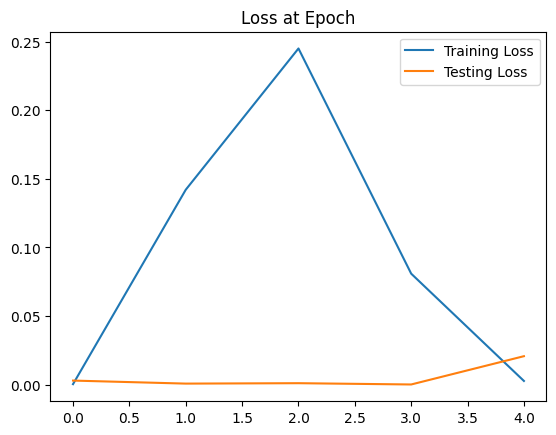

In [44]:
#Graph the loss at epoch
train_losses=[tl.item() if isinstance(tl, torch.Tensor) else tl for tl in train_losses] # Check if element is a tensor before calling .item()
test_losses=[tl.item() if isinstance(tl, torch.Tensor) else tl for tl in test_losses]  # Check if element is a tensor before calling .item()
plt.plot(train_losses,label='Training Loss')
plt.plot(test_losses,label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()


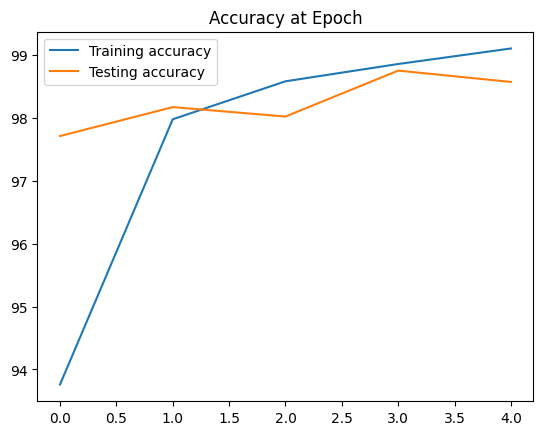

In [47]:
#Graph the accuracy
plt.plot([t/600 for t in train_correct],label='Training accuracy')
plt.plot([t/100 for t in test_correct],label='Testing accuracy')
plt.title('Accuracy at Epoch')
plt.legend()

In [50]:
#test
from torch.utils.data import DataLoader
test_load_everything=DataLoader(test_data,batch_size=10000,shuffle=False)

In [54]:
with torch.no_grad():
  correct=0
  for b,(X_test,y_test) in enumerate(test_load_everything):
    y_val=model(X_test)
    predicted=torch.max(y_val.data,1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test accuracy: {(correct/10000)*100}')

Test accuracy: 98.56999969482422


In [53]:
correct.item()

9857

In [55]:
#Grab an image
test_data[4143] #Tensor with an image in it...at end,it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [56]:
#Grab just the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [57]:
#Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

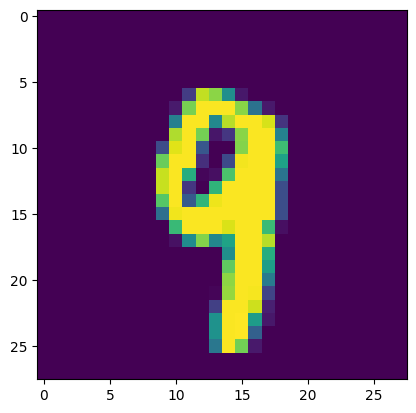

In [59]:
#shoewthe image
plt.imshow(test_data[4143][0].reshape(28,28))

In [60]:
#pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction=model(test_data[4143][0].view(1,1,28,28))

In [61]:
#check the new prediction... get probabilities
new_prediction

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [62]:
new_prediction.argmax()

tensor(9)